# Table of contents
1. [Objectives](#objectives)
2. [Data Acquisition](#data_aquisition) <br>
    2.1. [Data Source](#data_source) <br>
    2.2. [Dataset Basic Information](#dataset_basic_information) <br>
    2.3. [Applicable Algorithms](#applicable_algorithm) <br>
3. [Data Visualization](#data_exploration) <br>
    3.1. [Stores Sales Mean By Year](#stores_sales_mean_by_year) <br>
    3.2. [Rolling Mean & Standard Deviation Visualization](#rolling_mean) <br>
    3.3. [Store Sales Mean By Weekdays](#weekdays_sales_visualization) <br>
    3.4. [Stores Sales Mean By Month](#stores_sales_mean_by_month) <br>
    3.5. [Anomalies Detection](#anomalies_detection) <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.5.1. [Outliers Isolation](#outliers_isolation) <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.5.2. [Normalization Algorithm](#normalization_algorithm) <br>
4. [(S)ARIMA Models](#) <br>
    4.1. [Theoric Introduction to ARIMA and SARIMA Models](#) <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4.1.1. [AR Model](#) <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4.1.2. [MA Model](#) <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4.1.3. [ARIMA Model](#) <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4.1.4. [SARIMA Model](#) <br>
    4.2. [Stationarity](#) <br>
    4.3. [Parameters Identification](#) <br>
    4.4. [Evaluation](#) <br>
    4.5. [Results Interpretation](#) <br>
    4.6. [Forecast](#) <br>
5. [Extreme Gradient Boosting Trees Model](#) <br>

# Objectives <a name="objectives"></a>
The first objective is to predict 3 months of sales for 50 different items at 10 different stores.

The second objective is to answer each of the following questions:
- What's the best way to deal with seasonality? 
- Should stores be modeled separately, or can you pool them together? 
- Does deep learning work better than ARIMA? 
- Can either beat xgboost?

Technically, the objective is to predict the sales from 2018-01-01 to 2018-03-31 for stores 1 to 10 and items 1 to 50 in the test set where the train set is given.

# Data Acquisition <a name="data_aquisition"></a>

The objective is to get the train and test data sets and extract basic information before starting the data exploratory phase.

## Data Source <a name="data_source"></a>

The data come from Kaggle and are downloaded [here](https://www.kaggle.com/c/demand-forecasting-kernels-only/data).


## Dataset Basic Information <a name="dataset_basic_information"></a>

We need to know how much data do we have in our data sets to help us determining a list of algorithms that will suit better to achieve the objectives.

- Number of rows
- Number of columns
- Percentage: number of rows of a data set / total number of rows of test + train sets * 100


In [1]:
import math
import pandas
import numpy as np
import matplotlib.pyplot as plt
import datetime
import itertools
import statsmodels.api as sm
import scipy.stats as stats

from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller, kpss, acf
from random import randint

from Utils import *
import Anomalies

In [2]:
train = pandas.read_csv("Dataset/train.csv")
train_number_of_rows = len(train.index)
train_number_of_cols = len(train.columns)
print("Train set - Number of rows:", train_number_of_rows)
print("Train set - Number of columns:", train_number_of_cols)

test = pandas.read_csv("Dataset/test.csv")
test_number_of_rows = len(test.index)
test_number_of_cols = len(test.columns)
print("\nTest set - Number of rows:", test_number_of_rows)
print("Test set - Number of columns:", test_number_of_cols)

percentage_test = round(test_number_of_rows / (test_number_of_rows + train_number_of_rows) * 100, 2)
print("The test set contains", percentage_test, "% of the overall datasets.\n")

number_of_stores = len(set(train.store))
number_of_items = len(set(train.item))
print("Number of stores: ", number_of_stores)
print("Number of items per store: ", number_of_items, "\n")

print(train.head())
print(train.tail())

Train set - Number of rows: 913000
Train set - Number of columns: 4

Test set - Number of rows: 45000
Test set - Number of columns: 4
The test set contains 4.7 % of the overall datasets.

Number of stores:  10
Number of items per store:  50 

         date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10
              date  store  item  sales
912995  2017-12-27     10    50     63
912996  2017-12-28     10    50     59
912997  2017-12-29     10    50     74
912998  2017-12-30     10    50     62
912999  2017-12-31     10    50     82


## Applicable Algorithms <a name="applicable_algorithm"></a>
We know that we have the sales for the 5 past years (2013-01-01 to 2017-12-31) from which we have to forecast the sales for the next 3 months (2018-01-01 to 2018-03-31). 

As the objectives specified, the following algorithms will be used in order to predict the next 3 months of sales:
- Seasonal and non-seasonal ARIMA (including or not exogenous variables)
- Neural Networks
- XGBoost (Extreme Gradient Boosting Trees)

# Data Visualization <a name="data_exploration"></a>

The objective is to explore the training set in order to understand and visualize how the sales varies in function of the time for a random item of a random store. We take a random item because we only want to have an idea of how behave the sales and every time we will run this notebook, a new random item will be explored.

We have to check in the time series given in the train set:
- the seasonal behavior of the sales of the item in the store
- the seasonality and non seasonality trend of the sales over time
- the stationarity of the time series

Since this is items in stores demand, we know that it is about shopping. We are then interested on:
- __Sales by weekday__ because people may buy more on weekends (Friday, Saturday and Sunday), since most of people do not work on weekends.
- __Sales before, during and after holidays__ For example, people are generally in a rush to buy gifts just before Christmas (like December 23rd, December 24th). However, stores are mostly closed on Christmas.
- __Months or seasons (Winter, Spring, Summer and Fall)__ For example, if the store sells items used to sports practiced on Spring and Summer, people will start to buy on January or February until June or July in order to be ready for the Spring or/and Summer. Once the Summer will be at its end (August or September), it will be too late and then, the sales should decrease.
- __Anomalies__ because if the store got dammage or was robbed, the sales will be very low or even $0$. If there is a special event near the store, people may buy more items at that moment where normally the sales are not that good at that period of the year. That could also be human mistake that has impacts on the calculations of the sales.

## Stores Sales Mean By Year
One of the questions we have to answer from the main objectives is to know if we can apply the same model on all stores or should we apply a different model per store. One way to answer this is to visualize the sales pattern of the 10 stores.

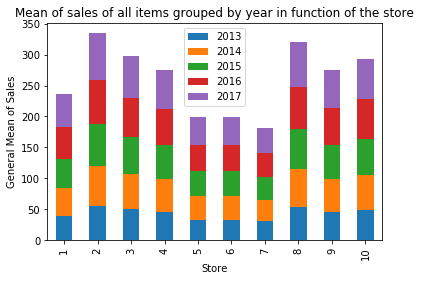

In [3]:
train_copy = train.copy()
train_copy.date = pandas.DatetimeIndex(train_copy.date)
train_copy.set_index('date', inplace=True)
store_year_mean = train_copy.groupby('store')['sales'].resample('YS').mean().reset_index()
store_year_mean = store_year_mean.set_index(['date', 'store']).stack().unstack('date').fillna(0)

dates = set(store_year_mean.stack().index.get_level_values(2))
dates = sorted([date.year for date in dates])

ax = store_year_mean.plot(kind='bar', 
                          stacked=True, 
                          title='Mean of sales of all items grouped by year in function of the store')
ax.set(xlabel='Store', ylabel='General Mean of Sales')
ax.set_xticklabels(store_year_mean.index.get_level_values('store'))
ax.legend(dates);

The store 7 has the lowest sales value whereas the stores 2 and 8 have the highest sales values. 

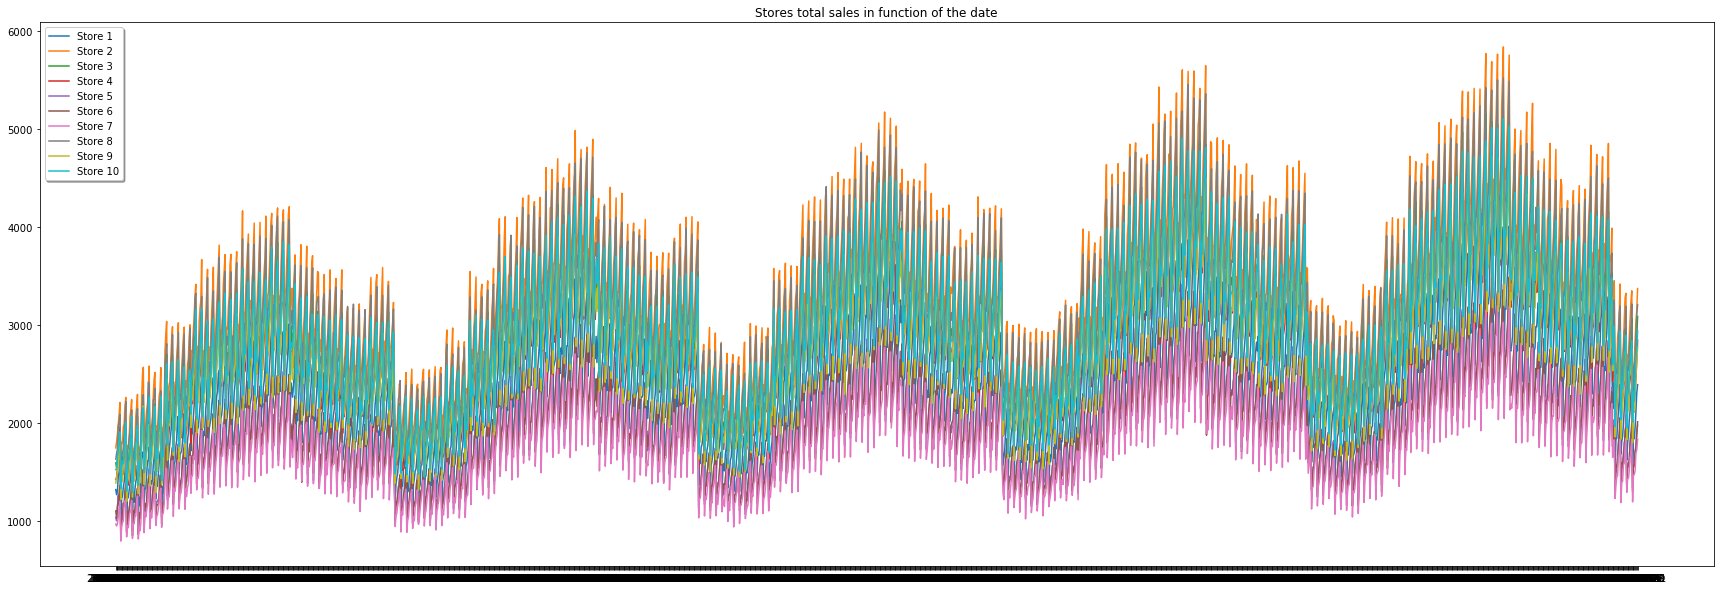

In [4]:
store_color_map = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

plt.figure(figsize=(30,10))
plt.title("Stores total sales in function of the date")

for store_id in range(number_of_stores):
    global_sales_of_store = pandas.pivot_table(train[train.store == store_id + 1], 
                                               index=['date'],
                                               columns=['store', ],
                                               values='sales',
                                               aggfunc=np.sum)
    plt.plot(global_sales_of_store, 
             color=store_color_map[store_id],
             label="Store " + str(store_id + 1))
plt.legend(loc='upper left', shadow=True);

## Rolling Mean & Standard Deviation Visualization <a name="rolling_mean"></a>
In a time series, the mean and standard deviation change in function of the time. In that case, we have to use the rolling mean and standard deviation in order to detect trends per month and also to overview the difference between the seasons for each year.

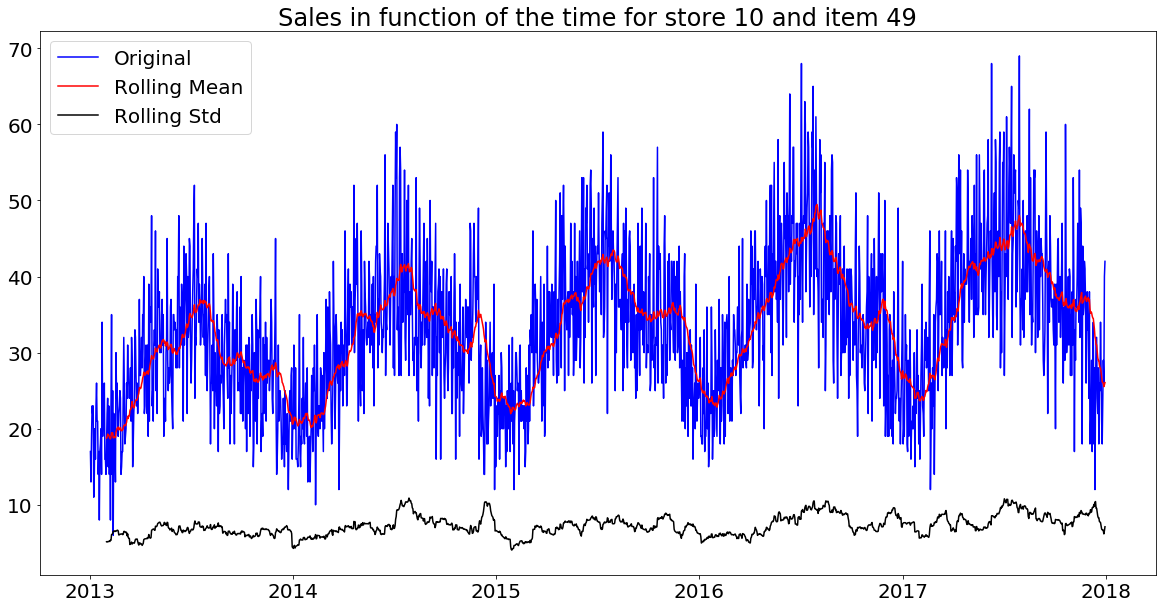

In [5]:
store_id = randint(1, 10)
item_id = randint(1, 50)

# Set the store index as the date with daily frequencies.
item = train.loc[(train.store == store_id) & (train.item == item_id), ['date', 'sales']]
item.date = pandas.DatetimeIndex(item.date)
item.set_index('date', inplace=True)
item = item.asfreq('D') 

# Determine the rolling means and the standard deviation per month.
rollmean = item.sales.rolling(30).mean()
rollstd = item.sales.rolling(30).std()

# Plot rolling mean and standard deviation.
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 20})
plt.plot(item, color='blue',label='Original')
plt.plot(rollmean, color='red', label='Rolling Mean')
plt.plot(rollstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title("Sales in function of the time for store " + str(store_id) + " and item " + str(item_id))
plt.show(block=False)

We clearly see a pattern of increasing and decreasing trends described by the mean every year. The variance is not varying significantly. Thus, there is no need to apply a logarithm or square root transformation on the sales in order to stabilize the variance. Let's take a look at the seasonal decomposition plot.

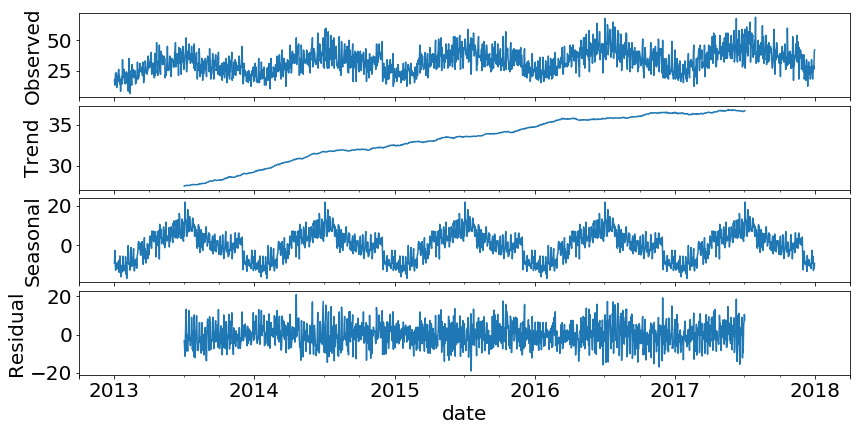

In [6]:
diagnostics = sm.tsa.seasonal_decompose(item, model='additive', freq=365)
diagnostics.plot()
plt.subplots_adjust(left=None, bottom=None, right=2, top=1.5, wspace=None, hspace=0.1)
plt.show()

From the trend plot, we see that the sales trend increase slowly over years which shows the non stationarity of the time series. We also see the pattern on the seasonal plot where this pattern is repeated every year. 


## Store Sales Mean By Weekdays <a name="weekdays_sales_visualization"></a>
We also want to visualize which week days have the best sales.

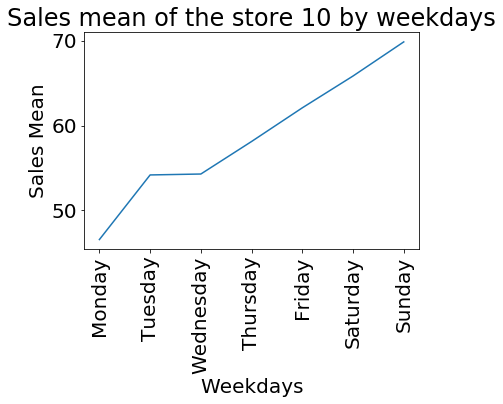

In [7]:
import calendar

store = train.loc[train.store == store_id, ['date', 'sales']]
store.date = pandas.DatetimeIndex(store.date)
store.set_index('date', inplace=True)

store_mean_by_day = store.groupby(store.index.dayofweek).mean()
ax = store_mean_by_day.plot(legend=None, title="Sales mean of the store " + str(store_id) + " by weekdays")
ax.set(xlabel='Weekdays', ylabel='Sales Mean')
ax.xaxis.set_ticks(np.arange(len(list(calendar.day_name))))
ax.xaxis.set_ticklabels(list(calendar.day_name), rotation=90);

We see that the sales increase in general from Monday to Sunday. However, Saturday and Sunday are the week days with the best sales. This follows the fact that people are shopping on weekends because they are mostly working on business days. Furthermore, stores may be opened later on Friday which could explain why the sales increased considerably from Friday to Sunday.


## Stores Sales Mean By Month <a name="stores_sales_mean_by_month"></a>
The objective is to visualize the sales mean by month in order to observe if there is a clear pattern and then deduce the stationarity of the time series.

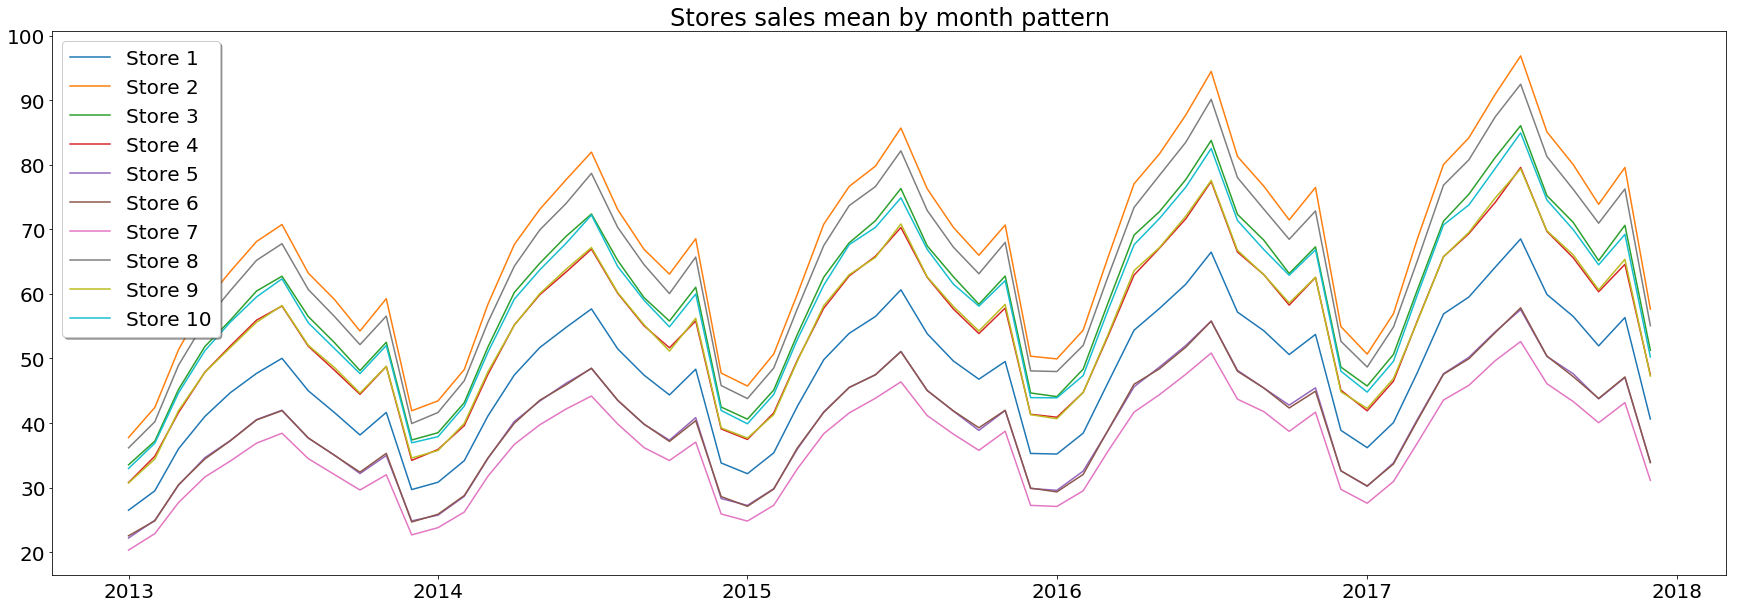

In [8]:
train['month_number'] = pandas.DatetimeIndex(train['date']).month

store_color_map = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
plt.figure(figsize=(30, 10))
plt.title("Stores sales mean by month pattern")

for i in range(number_of_stores):
    store = train.loc[train.store == i+1, ['date', 'sales']]
    store.date = pandas.DatetimeIndex(store.date)
    store.set_index('date', inplace=True)
    
    store_by_month_mean = store['sales'].resample("MS").mean()
    plt.plot(store_by_month_mean, 
             color=store_color_map[i],
             label="Store " + str(i+1))
plt.legend(loc='upper left', shadow=True);

The following observations are identified:
- The trend increases slowly from year to year.
- The trend is clearly varying from month to month. 
- The trend seems to follow a similar pattern year after year. 

The time series has a seasonality pattern. In general, we have the following observations:
- From January to June, the sales are increasing. 
- It may occur that from March to April, the sales decreases a little.
- From June to September, the sales are decreasing.
- From September to October, the sales are increasing.
- From October to December, the sales are decreasing.
- From December to January, the sales are increasing. (It may occur that the sales continue to decrease.)

According to this plot, we assume that one model should fit for all stores in this dataset because their pattern is similar between them.

In order to know if the month of the year is important, we want to visualize what are the sales mean of all stores for every month of the 5 years. 

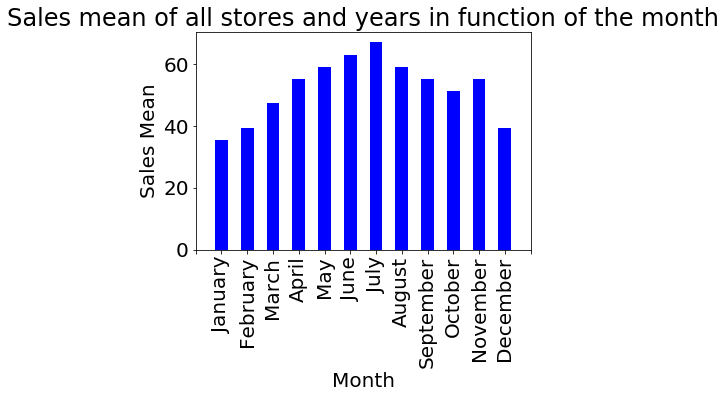

In [9]:
ax = train[['sales','month_number']].groupby(["month_number"]).mean().plot.bar(color='blue', legend=None)
plt.title("Sales mean of all stores and years in function of the month")
plt.xlabel('Month')
plt.ylabel('Sales Mean')
plt.figure(figsize=(15, 10))
ax.xaxis.set_ticks(np.arange(-1, len(list(calendar.month_name))))
ax.xaxis.set_ticklabels(list(calendar.month_name), rotation=90);
plt.show()

There is a considerable increasing of sales starting on Spring season (on March) and we observe that May, June, July and August have the highest sales of the year. We assume that those stores are selling items related to the Summer season. However, note that there is a suddent increase of sales on November.

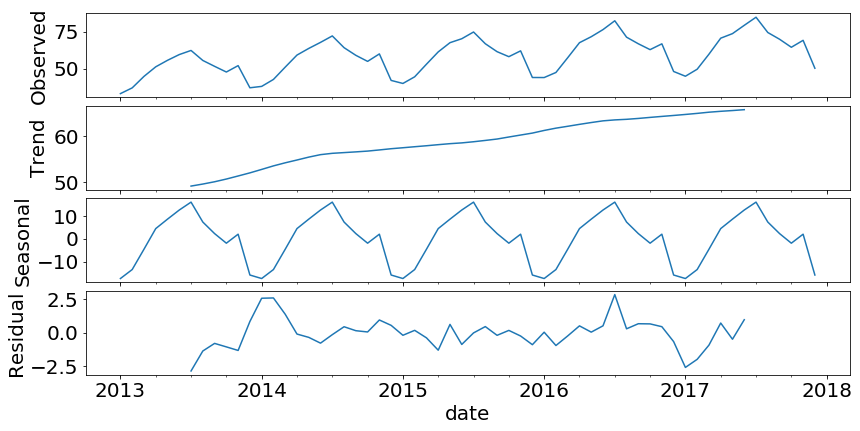

In [10]:
diagnostics = sm.tsa.seasonal_decompose(store_by_month_mean, model='additive')
diagnostics.plot()
plt.subplots_adjust(left=None, bottom=None, right=2, top=1.5, wspace=None, hspace=0.1)
plt.show()

The trend is not constant implying that the time series is not stationary. We see that the pattern is clear for the seasonal time series which is repeated every year.


## Anomalies Detection <a name="anomalies_detection"></a>
The objective is to detect sales that are increasing or decreasing significantly in few days compared to the others. This should help to identify particular dates and then verify if there these were special events on these dates. Identifying the outliers in this context will be used (as exogenous variables or new features) to help the models getting more accurate when predicting future sales. For example, if a special event occurs every year where the sales increase significantly, we should see these outliers every year at the same date.

Furthermore, we do not have enough information on the stores and items to confirm that incorrect sales have been entered by mistake or something like that. Therefore, the objective is not to remove those outliers but to get insights to help the models.

Let's see the scatter plot of an item taken randomly in order to visualize data points that may be consider as outliers.

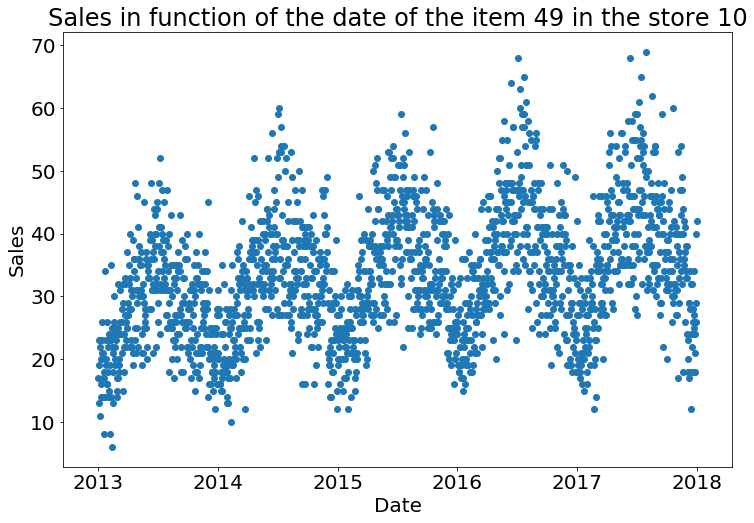

In [11]:
plt.figure(figsize=(12, 8))
plt.scatter(x=item.index, y=item.sales)
plt.title("Sales in function of the date of the item " + str(item_id) + " in the store " + str(store_id))
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

According to this scatter plot, the following actions could be used to detect outliers:
- If the sales considered as anomalies occur during holidays or special events, we could use a method to isolate them. 
- It could make sense that if a special event occurs, the sales increase significantly compared to the days before. In such case, comparing the data point against the distance from the rolling mean has to be considered.

### Outliers Isolation <a name="outliers_isolation"></a>
Another way to detect outliers is to use the isolation forest algorithm. The objective of this algorithm is to isolate data points based on the assumption that outliers are data points that are different from the others and rare. Therefore, only few conditions are necessary to find outliers contrarily to the normal data points. (ref. [solation-based Anomaly Detection](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/tkdd11.pdf))

Since the algorithm uses random decision trees, more the path to reach a data point is short, more the data point is an outlier. Due to the randomness of the algorithm, the process is repeated a certain number of times and the normalized average path length is taken as the score.

The following steps are followed:
1. Find features that could add more conditions in order to get a better accuracy of the outliers found.
2. Add the new features to the model.
3. Determine an estimated proportion of the outliers over the normal data points in a sample.
4. Apply the model to the time series in order to obtain the outliers.



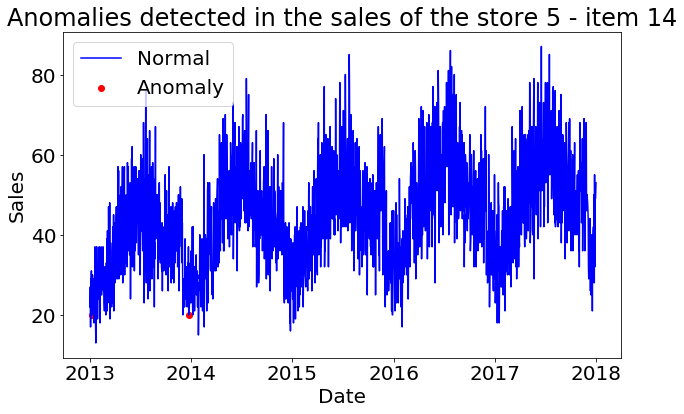

In [12]:
outliers_fraction = 5 / len(item.sales)

train['anomaly_iforest'] = Anomalies.ListAllByApplyingIsolationForest(train, outliers_fraction)
Anomalies.PlotRandomStoreItem(train, anomaly_type='iforest')

### Normalization Method
This statistical method consists to calculate the difference between the sales mean and the actual sales and then divide the result by the standard deviation (which is the normalization of the sales assuming the sales are normally distributed). The score is defined by
$$S(X_i) = \left|\frac{X_i - \mu}{\sigma}\right|$$
where $X_i$ is the sample $i$ of the sales $X$ in the dataset, $\mu$ is the mean of $X_i$ and $\sigma$ is the standard deviation of $X_i$. In function of a positive threshold $\tau$ chosen, all $x_i \in X_i$ such that $S(X_i) > \tau$ are called outliers. 

Before using this method, we have to make sure that the sales samples $X_i \sim N(\mu, \sigma^2)$. In order to verify the normality of $X_i$, we have to apply a normality test on every sample $X_i$. 

More concretely, we define $X_{s,i,m}$ as a sample of a store $i \in \{1, 2, \ldots, 10\}$ containing items $s \in \{1, 2, \ldots, 10\}$ where the sales are taken in the month $m \in \{1, 2, \ldots, 12\}$ from 2013-01-01 to 2017-12-31. This gives $10 \times 50 \times 12 \times 5 = 30000$ samples of size between $28$ and $31$ which represent the number of days based on the month.

The objective is to test the following hypotheses:
- $H_0$ the sales in the sample $X_{s,i,m}$ come from a population normally distributed.
- $H_1$ the sales in the sample $X_{s,i,m}$ come from a population that is not normally distributed.

If $p < \alpha$, where $p$ is the p-value and $1 - \alpha$ the confidence degree, the null hypothesis $H_0$ is rejected. In such case, it is probable that the sales comes from a population not normally distributed. If $p \geq \alpha$, the null hypothesis $H_0$ is not rejected. In such case, it is probable that the sales comes from a population normally distributed.

We expect that the samples will follow a normal distribution because we assume that there are great sales and bad sales in a month. However, it may happen that the sales were great all the month meaning that the sales will not be normally distributed for that month.

We use the Shapiro-Wilk test 

In [13]:
normality, anomalies = Anomalies.ListAllByApplyingNormalization(train, number_of_std=2.3, alpha=0.05)

percentage_of_normality = (sum(1.0 for n in normality if n == 1) / len(normality)) * 100
percentage_of_not_normality = round(100 - percentage_of_normality, 2)
percentage_of_normality = str(round(percentage_of_normality, 2))
print(percentage_of_normality + "% of the samples are normally distributed.")
print(str(percentage_of_not_normality) + "% of the samples are not normally distributed.")

93.9% of the samples are normally distributed.
6.1% of the samples are not normally distributed.


According to the percentages obtained from the Shapiro-Wilk normality test, the sales by month mostly follow the normal distribution with $95$% of confidence.

No handles with labels found to put in legend.


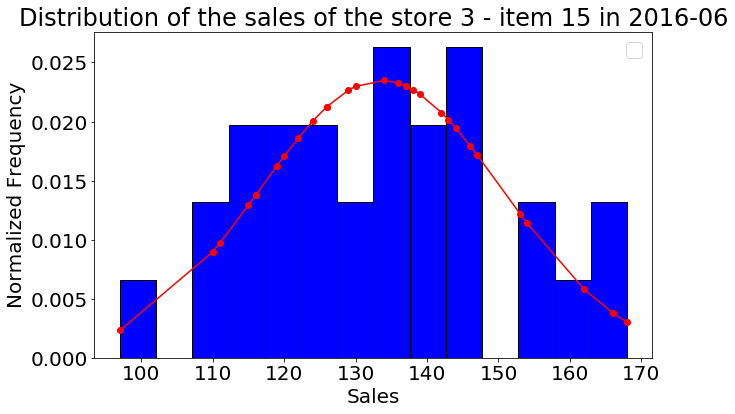

In [14]:
store_item = train.loc[(train.store == 3) & (train.item == 15), ['date', 'sales', 'month_number']]
store_item.date = pandas.DatetimeIndex(store_item.date).year
item_2016 = sorted(store_item.sales[(store_item.date == 2016) & (store_item.month_number == 6)])

plt.figure(figsize=(10, 6))
plt.hist(item_2016,
         color = 'blue', 
         edgecolor = 'black',
         bins=int((max(item_2016) - min(item_2016)) / 5),
         normed=True)

fit = stats.norm.pdf(item_2016, np.mean(item_2016), np.std(item_2016))

plt.plot(item_2016, fit, '-o', color='red')
plt.title("Distribution of the sales of the store 3 - item 15 in 2016-06")
plt.xlabel('Sales')
plt.ylabel('Normalized Frequency')
plt.legend()
plt.show()

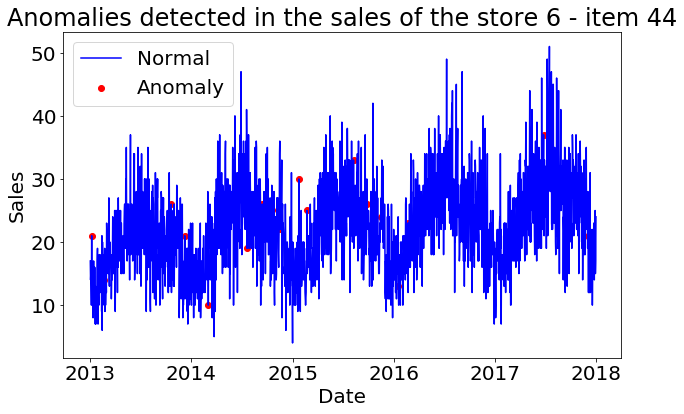

In [15]:
train['anomaly_normal'] = anomalies
Anomalies.PlotRandomStoreItem(train, anomaly_type='normal')

# (S)ARIMA Model <a name="sarima_model"></a>
As one of the main objective of this analysis specified, we have to compare the accuracy and performance of the ARIMA model to a neural network model (deep learning) or XGBoost model. According to this objective, we have to apply the best ARIMA model on our dataset and capture the running time and the accuracy of the predictions. 

The second objective is to determine if a single model is sufficient to predict the next 3 months (2018-01-01 to 2018-03-31) sales for the $50$ items of each of the $10$ stores. In other terms, we have to compare the accuracy of the single model predicting sales for all stores to $10$ models, one for every store.

ARIMA stands for AutoRegressive Integrated Moving Average models. In our business context, it is a forecasting technique that predicts the future sales in function of the past sales. ARIMA is composed of the 3 following parts:
- The AutoRegressive $AR(p)$ model refers to a regression model where the time series is explained by the effect of its past values on a period of time $p$. A one-time error (or shock) affects the evolving values (sales in our context) infinitely far into the future.
- The Integration $I(d)$ model represents the differencing of raw observations in order to allow for the time series to become stationary. In our business context, it means that the sales values in the dataset that are daily are replaced by the difference $d$ in days between the current sales values and the past sales values.
- The Moving Average $MA(q)$ model refers to a regression model where the time series is explained by the effect of the current and past errors. However, an error affects the observations (sales in our context) only for the current and the $q$ period(s) of time into the future. 

In order to fulfill our objective, we will use the Box-Jenkins methodology. The methodology consists of 3 high-level steps:
- Identify the model parameters and stationarize the time series.
- Estimate the model with the parameters found and find the best combination of parameters, then use diagnostics on this model in order to judge if the model is suitable or not.
- Forecast the future sales of the time series and determine a confidence interval on these forecasts.


## Theoric Introduction to ARIMA and SARIMA Models <a name="theoric_introduction_to_arima"></a>
Let's start by some definitions and notations:
- Let $T = \{0, 1, \ldots, n\}$ be the set of times represented by the date in the dataset. Since the date starts on 2013-01-01, we define the time $t \in T$ in days such that $t = 0$ is 2013-01-01, $t = 1$ is 2013-01-02 until it reaches $t = n$ which is 2017-12-31. In the same idea, we define $\hat{T} = {n+1, n+2, \ldots, n+m}$ the set of future time given in the test set. Time $t = n+1$ is 2018-01-01, time $t=n+2$ is 2018-01-02 until it reaches $t = n+m$ which is 2018-03-31.
- Let $X_0, X_1, \ldots, X_n$ be the endogenous variables represented by the sales at time $t \in T$ given in the train dataset.
- We define the time series as $\{X_t, t \in T\}$.
- Let $L$ be the lag operator defined by $LX_t = X_{t-1}, L^2X_t = X_{t-2}, \ldots, L^kX_t = X_{t-k}$ where $t \geq k$. 
- Let $\Delta$ be the non-seasonal differencing operator such that $\Delta X_t = (1 - L)X_t = X_t - X_{t-1}$. For example, the second order differencing is $\Delta^2 X_t = (1 - L)^2X_t = (L^2 - 2L + 1)X_t = X_{t-2} - 2X_{t-1} + X_t$.
- Let $\Delta_s$ be the seasonal differencing operator such that $\Delta_s X_t = (1 - L^s)X_t = X_t - X_{t-s}$. For example, the second order differencing is $\Delta_s^2 X_t = (1 - L^s)^2 X_t = (L^{2s} - 2L^s + 1) X_t = X_{t-2s} - 2X_{t-s} + X_t$.
- Let $\hat{X}_t$ be our sales prediction of $X_t$ at time $t \in \hat{T}$.
- Let $\epsilon_t = X_t - \hat{X}_t$ the error between our sales prediction and the real value of the sales at time $t \in T$. We assume that $\epsilon_t \sim N(0, \sigma^2)$ is a white noise process and i.i.d.


### Model $AR(p)$ <a name="ar_model"></a>
The autoregressive model of order $p$ can be written as
$$X_t = (\alpha_1 X_{t-1} + \alpha_2 X_{t-2} + \dots + \alpha_p X_{t-p}) + \epsilon_t$$ or equivalently $$\epsilon_t = \left(1 - \sum_{i = 1}^p \alpha_i L^i\right) X_t.$$

Let $\phi(L) = \left(1 - \sum_{i = 1}^p \alpha_i L^i\right)$ be the characteristic polynomial of the model where $\alpha = (\alpha_1, \alpha_2, \ldots, \alpha_p) \in \mathbb{R}^p$ is the vector of model coefficients. Therefore, we have $X_t \sim AR(p)$ where $\epsilon_t = \phi(L)X_t$.

It has been proven by Box and Jenkins that an $AR(p)$ process is stationary if and only if the roots $\lambda_1, \lambda_2, \ldots, \lambda_p \in \mathbb{C}$ of the characteristic polynomial ($\phi(L) = 0$) are outside the unit circle. This means that $|\lambda_1| > 1, |\lambda_2| > 1, \ldots, |\lambda_p| > 1$.

For example, a model $AR(1)$ is defined as 
$$\epsilon_t = X_t - \alpha_1 X_{t-1} = (1 - \alpha_1 L)X_t.$$ 
The characteristic polynomial is $\phi(L) = (1 - \alpha_1 L)$. We have $\phi(L) = 0$ if and only if we have the root $\lambda_1 = \frac{1}{\alpha_1}$ where $\alpha_1 \neq 0$. The process is stationary if and only if $|\alpha_1| < 1$. Hence, if $\epsilon_t = X_t - 0.81 X_{t-1} = (1 - 0.81 L)X_t.$, the process is stationary because $|0.81| < 1$.


### Model $MA(q)$ <a name="ma_model"></a>
The moving average model of order $q$ can be written as
$$X_t = \epsilon_t + (\beta_1 \epsilon_{t-1} + \beta_2 \epsilon_{t-2} + \dots + \beta_q \epsilon_{t-q}) = \left(1 + \sum_{i = 1}^p \beta_i L^i\right) \epsilon_t.$$ 

Let $\theta(L) = \left(1 + \sum_{i = 1}^q \beta_i L^i\right)$ be the characteristic polynomial of the model where $\beta = (\beta_1, \beta_2, \ldots, \beta_p) \in \mathbb{R}^p$ is the vector of model coefficients. Therefore, we have $X_t \sim MA(q)$ where $X_t = \theta(L)\epsilon_t$. Note that a process $MA(q)$ is always stationary whatever the values of $\beta_i \in \beta$.

For example, a model $MA(1)$ is defined as $$X_t = \epsilon_t + \beta_1 \epsilon_{t-1} = (1 + L\beta_1)\epsilon_t$$.


### Model $ARIMA(p, d, q)$ <a name="arima_model"></a>
The ARIMA model is a non seasonal model using the past observations and the past errors as explanatory variables in order to describe future observations. In a first step, this model combines the $AR(p)$ and $MA(q)$ models which gives the $ARMA(p, q)$ model. This model can be written as
$$\phi(L)X_t = \theta(L)\epsilon_t.$$
The $ARMA(p, q)$ process is stationary if and only if the process $AR(p)$ is stationary.

Introducing the integration model $I(d)$ that differentiates with a lag $d \in \mathbb{N}$ the current and past sales (endogenous variables) $X_{t-i}$ for $i = 0,1,\ldots,n$, this leads to the $ARIMA(p,d,q)$ model defined by
$$\phi(L)\Delta^d X_t = \theta(L)\epsilon_t.$$

For example, a model $ARIMA(0, 1, 1)$ is defined by 
$$\Delta X_t = (1 + L\beta_1) \epsilon_t$$ which is equivalent to
$$X_t - X_{t-1} = \epsilon_t + \beta_1 \epsilon_{t-1}.$$

As a second example, a model $ARIMA(2, 1, 1)$ is defined by
$$(\alpha_1 L + \alpha_2 L^2) \Delta X_t = (1 + L\beta_1) \epsilon_t$$ which is equivalent to
$$(\alpha_1 X_{t-1} + \alpha_2 X_{t-2}) - (\alpha_1 X_{t-2} + \alpha_2 X_{t-3}) = \epsilon_t + \beta_1 \epsilon_{t-1}$$ if and only if
$$\alpha_1(X_{t-1} - X_{t-2}) + \alpha_2(X_{t-2} - X_{t-3}) = \epsilon_t + \beta_1 \epsilon_{t-1}.$$


### Model $SARIMA(p, d, q)\times(P, D, Q)_s$ <a name="sarima_model"></a>
The SARIMA model introduces the seasonal as a multiplicative part of the ARIMA model. The models $SAR(P)_s$ and $SMA(Q)_s$ are similar as the models $AR(p)$ and $MA(q)$ respectively. The seasonality evolves according to a cyclic pattern.

For example, in a time series of monthly sales in a certain store the mean sales is not constant, since it varies by month, but for the same month in different years we expect a constant average value.

The seasonal autoregressive model $SAR(P)_s$ is defined by
$$\epsilon_t = \left(1 - \sum_{i = 1}^P a_i L^{si}\right) X_t.$$
Let $\Phi(L) = \left(1 - \sum_{i = 1}^P a_i L^{si}\right)$ be the characteristic polynomial of the model. The model can be rewritten as
$$\epsilon_t = \Phi(L)X_t.$$

The seasonal integrated model $SI(D)_s$ is defined by
$$\Delta_s^D X_t = (1 - L^s)^D X_t.$$

The seasonal moving average model $SMA(Q)_s$ is defined by
$$X_t = \left(1 + \sum_{i = 1}^Q b_i L^{si}\right) \epsilon_t.$$
Let $\Theta(L) = \left(1 + \sum_{i = 1}^Q b_i L^{si}\right)$ be the characteristic polynomial of the model. The model can be rewritten as
$$X_t = \Theta(L)\epsilon_t.$$

Therefore, the $SARIMA(p,d,q)\times(P,D,Q)_s$ model can be written as
$$\phi(L)\Delta^d \Phi(L)\Delta_s^D X_t = \theta(L) \Theta(L) \epsilon_t.$$


## Stationarize Sales Time Series <a name="stationarize_model"></a>
The first step of the Box-Jenkins methodology is to transform the time series data in order to achieve the stationarity of the process. We need to verify if the following transformations are necessary to achieve the stationarity of the process:
- Logarithm or square root transformation of the time series.
- Differencing the time series until the stationarity is obtained.

After any transformation of the time series, we test the stationarity of the time series with the Augmented Dickey-Fuller test.

Since the variance of the sales was not varying significantly (see in Data Exploration section), there is no need to transform the data with a logarithm or a square root. We focus instead on the differencing of the time series.

### Augmented Dickey-Fuller Test <a name="stationarity"></a>
We want to stationarize the time series in order to obtain statistics such as the mean, variance and correlation with other variables as descriptors of how the future sales will behave.

One way to check the stationarity of the time series in function of the store and the item is to perform the Augmented Dickey-Fuller test. Since we want to test with drift and deterministic time trend, we define the regression model by 
$$\Delta X_t = c_0 + c_1t + (\phi_1 - 1) X_{t-1} + \epsilon_t$$
where $\Delta$ is the fist difference operator, $c_0$ is the drift and $c_1$ the coefficient for the time trend. Note that $X_t = \phi_1 X_{t-1} + \epsilon_t$ is the $AR(1)$ model that is defined in the $AR(p)$ Model section below.

We deduce from the linear model that there is a unit root only if $\phi_1 = 1$ because $X_t$ depends on passed observation $X_{t-1}$. Having $\phi_1 = 1$ gives $\Delta X_t = c_0 + c_1t + \epsilon_t$ which is the unit root.

We set the following hypotheses: 
- $H_0$: There is a unit root in $\Delta X_t$ implying that the time series is stationary.
- $H_1$: There is no unit root in $\Delta X_t$ implying that the time series is not stationary. 

Let $z$ be the test statistic and $z_{1-\alpha}$ be the critical value at a confidence level of $100(1-\alpha) \%$. Using the Dickey-Fuller critical value table with more than $500$ observations, drift and time trend, we have:
- For $\alpha = 0.99$, the critical value is $z_{0.01} = -3.96$
- For $\alpha = 0.95$, the critical value is $z_{0.05} = -3.41$
- For $\alpha = 0.90$, the critical value is $z_{0.10} = -3.12$

We choose that if $z < z_{0.01}$, we reject the null hypothesis $H_0$ and the time series is stationary. If $z \geq z_{0.01}$, we do not reject $H_0$ and the time series is not stationary.

Let's check if our store time series is stationary or not with this test without differencing the time series.

In [16]:
TestStationarity(item.sales, 0.01)

Results of the Augmented Dickey-Fuller Test:
-----------------------------------------------------

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     87.75
Date:                Thu, 07 Feb 2019   Prob (F-statistic):          2.11e-280
Time:                        21:21:40   Log-Likelihood:                -5967.8
No. Observations:                1802   AIC:                         1.199e+04
Df Residuals:                    1777   BIC:                         1.212e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

### Original Time Series ACF & PACF <a name="original_time_series"></a>
We have to plot the ACF (Auto-Correlation Function) and PACF (Partial Auto-Correlation Function) using the sales data in order to identify which models could be used (AR, MA or ARMA).

The ACF is defined by
$$ACF(k) = \frac{Cov(X_t, X_{t-k})}{Var(X_t)} = \frac{\sum_{t = 1}^{n-k} (X_t - \bar{X})(X_{t+k} - \bar{X})}{\sum_{t = 1}^n (X_t - \bar{X})^2}$$
where $\bar{X}$ is the sales mean.

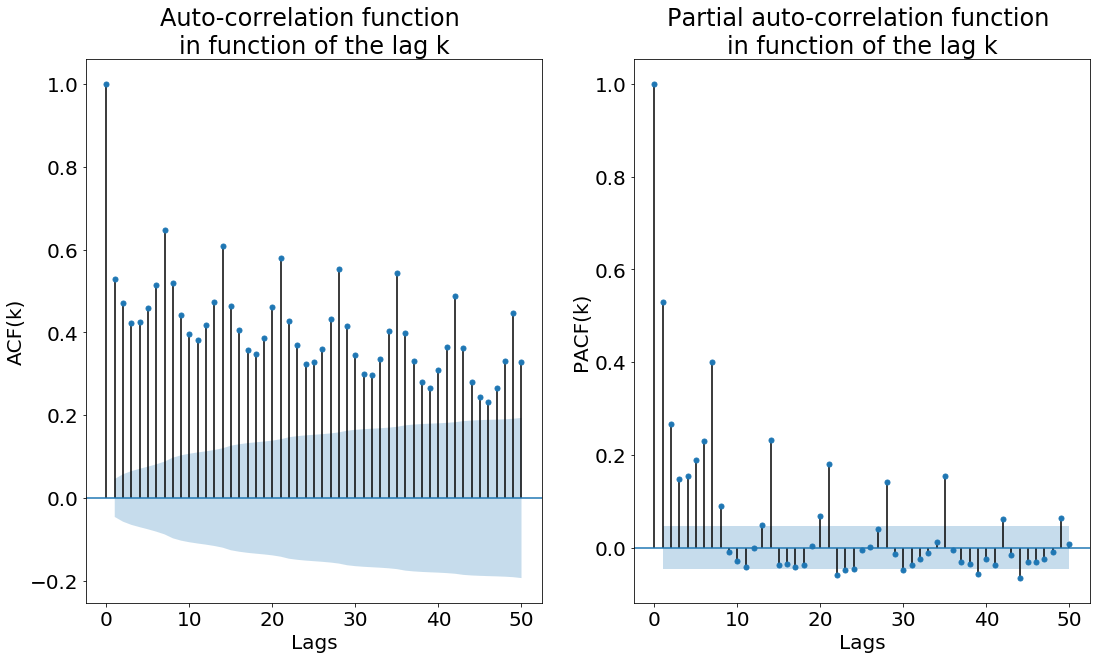

In [17]:
PlotAutoCorrelation(item.sales, [50, 50])

original_acf = acf(item.sales, nlags=50)
#print(original_acf)

We see the following observations in the ACF and PACF:
- Significant spikes at lags $7s$ in the ACF and the PACF. Since the sales have been taken daily, we deduce that there are weekly seasons because of the spikes at every 7 days and the seasonal pattern from $7s - 6$ to $7s$.
- The ACF decreases slowly and will reach $0$ at a certain lag. This suggests an $AR(p)$ model with $0 < \alpha_1 < 1$. However, if we look at the same plot but with lags $k < 300$, we see a sinusoidal style curve.
- There is an exponential decay in the PACF which suggests a $MA(q)$ model. We see significant spikes at lags $1,2,3,4,5,6,7$ where the lag $7$ is the seasonal lag. Hence, a $MA(7)$ model could be viable. 

Except for seasons, we cannot determine what are the parameters easily. After taking the first order differencing, we should have a better idea because we expect that the trend be stationary.


### First Order of Differencing Time Series <a name="first_order"></a>
The objective is to see if we can achieve the stationarity of the time series after a first seasonal and non-seasonal order differencing. The purpose of differencing the time series is to remove trends transform the time series to a stationary one. 

In [18]:
sales_diff_non_seasonal = item.sales - item.sales.shift(1)
sales_diff_non_seasonal.dropna(inplace=True)

sales_diff_seasonal = item.sales - item.sales.shift(7)
sales_diff_seasonal.dropna(inplace=True)

Let's plot the non seasonal and seasonal differenced time series with their mean and standard deviation.

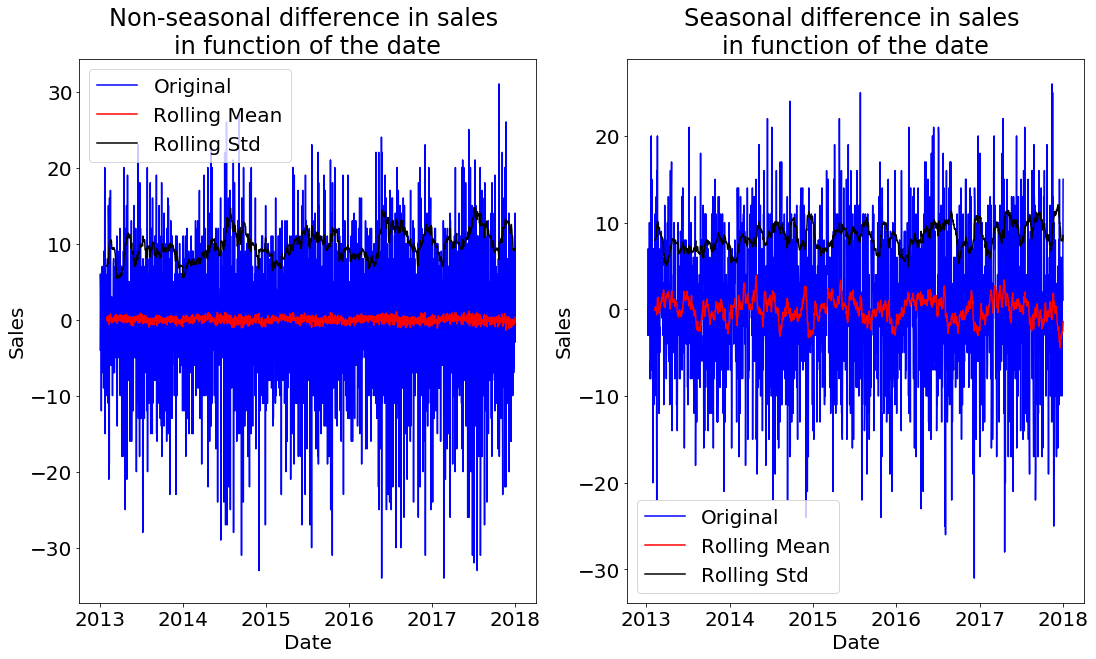

In [19]:
rolmean = sales_diff_non_seasonal.rolling(30).mean()
rolstd = sales_diff_non_seasonal.rolling(30).std()

plt.figure(figsize=(18, 10))
plt.subplot(1, 2, 1)
plt.plot(sales_diff_non_seasonal, color='blue',label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Non-seasonal difference in sales \nin function of the date')


rolmean = sales_diff_seasonal.rolling(30).mean()
rolstd = sales_diff_seasonal.rolling(30).std()

plt.subplot(1, 2, 2)
plt.plot(sales_diff_seasonal, color='blue',label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Seasonal difference in sales \nin function of the date')
plt.show()

We observe that the mean is quite independent of the time making the first differencing time series stationary. Indeed, in order to get the stationarity of the time series $\{X_t, t \in T\}$, we have to have $E[X_t] = 0$ for all $t \in T$. Lets verify our interpretation with the Dickey-Fuller test.

In [20]:
p_value_limit = 0.05
TestStationarity(sales_diff_non_seasonal, p_value_limit)
TestStationarity(sales_diff_seasonal, p_value_limit)

Results of the Augmented Dickey-Fuller Test:
-----------------------------------------------------

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     406.0
Date:                Thu, 07 Feb 2019   Prob (F-statistic):               0.00
Time:                        21:21:41   Log-Likelihood:                -5972.9
No. Observations:                1802   AIC:                         1.199e+04
Df Residuals:                    1778   BIC:                         1.213e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

We see that after differencing once our time series, we obtain its stationarity. Therefore, we found the following parameters:
- $s = 7$
- $d = 0$ 
- $D = 1$


## Model and Parameters Identification <a name="model_parameters_identification"></a>
We found the differencing order for the seasonal and non seasonal time series with its seasonality which is weekly. We have to find what is the value of the parameters $p,q$ for the non seasonal part and $P, Q$ for the seasonal part. 


### Non Seasonal ACF & PACF <a name="non_seasonal_acf_pacf"></a>
Let's see what the non-seasonal ACF and PACF look like for the first differencing order.

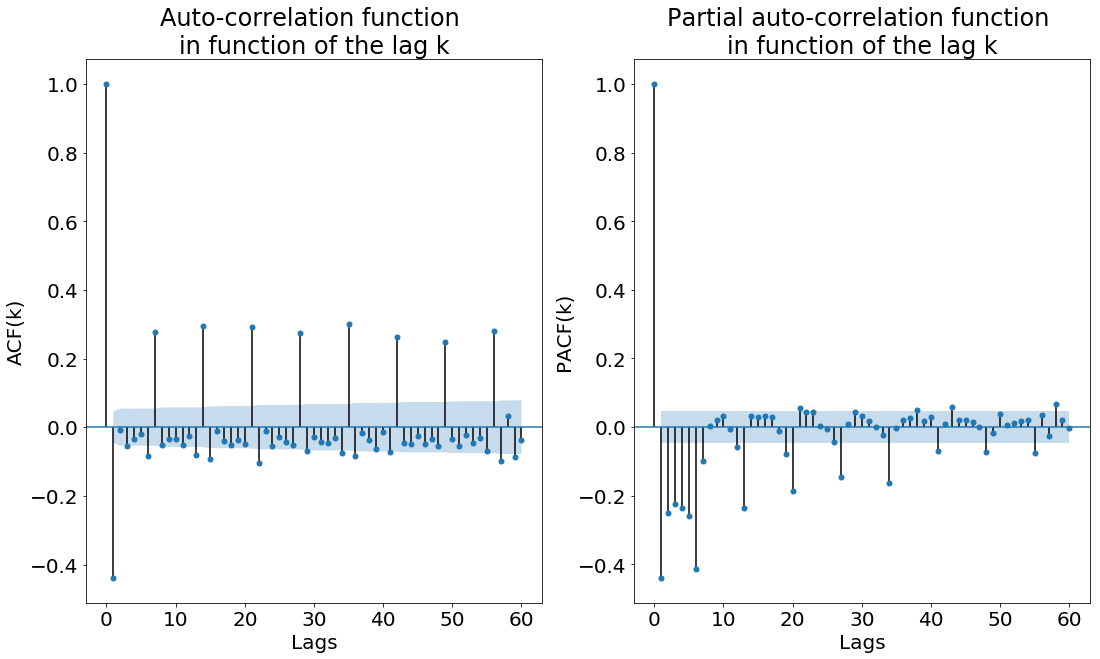

In [21]:
PlotAutoCorrelation(sales_diff_non_seasonal, [60, 60])

After a first order of differencing, we observe the following properties in the ACF and PACF plots:
- In the ACF, the spike at the lag $1$ is considerably negative compared to the others. This may suggest a $MA(1)$ process. However, the first lag seems to be significantly negative (close to $-0.5$). This suggests that the series has been over-differenced.


### Seasonal ACF & PACF <a name="seasonal_acf_pacf"></a>
Let's see what the first differencing time series seasonal ACF and PACF look like.

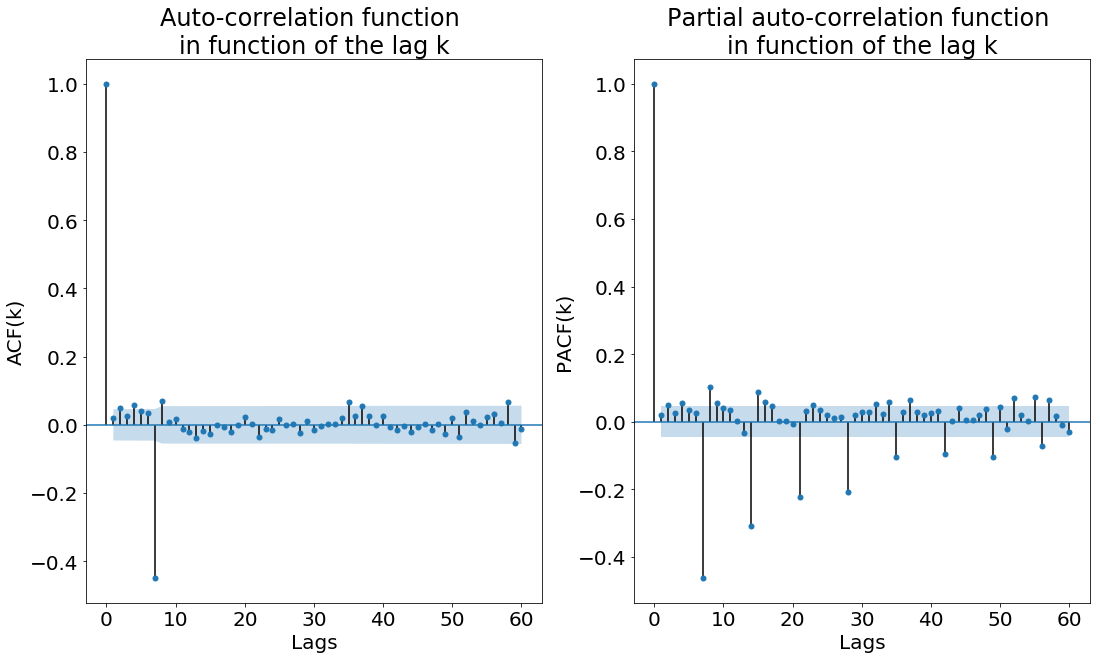

In [22]:
PlotAutoCorrelation(sales_diff_seasonal, [60, 60])

The differenced seasonal ACF and PACF suggest that this is a $SMA(1)$ model because the ACF shows a significant spike at the first seasonal lag $s = 7$ and an exponential decay in the PACF in the seasonal lags. Therefore, the seasonal part of the model suggests a $SARIMA(0, 1, 1)_7$ model.

Combining the seasonal and non seasonal models, we obtain
$$X_t \sim SARIMA(6, 1, 0)\times(0, 1, 1)_7$$


### Model Suggested Evaluation <a name="model_suggested_evaluation"></a>
With the observations we got by using the seasonal and non seasonal ACF and PACF, we conclude on the $SARIMA(6, 1, 0)\times(0, 1, 1)_7$ process. In order to evaluate if our process is good or not, we use the AIC (Akaike information criterion). The AIC is a measure of how well a model fits a dataset, while adjusting for the ability of that model to fit any dataset whether or not it is complex.

Lower value of the AIC suggests that the model is getting better. A better model is a simple model using less parameters and obtaining a higher accuracy. The AIC of a model $m$ is represented by
$$AIC_m = 2k_m - 2\ln(\mathcal{L}_m)$$
where $k_m = p + q + P + Q + 1$ is the number of parameters to estimate in the model $m$ and $\mathcal{L}_m$ is the maximum likelihood function of the model $m$.

## Models Evaluation <a name="model_estimation"></a>


In [23]:
periodicity = 7
non_seasonal_parameter = (6, 1, 0)
seasonal_parameter = (0, 1, 1, periodicity)

sarima_model = sm.tsa.statespace.SARIMAX(item.sales, 
                                         freq='D', 
                                         order=non_seasonal_parameter,
                                         seasonal_order=seasonal_parameter,
                                         enforce_stationarity=False, 
                                         enforce_invertibility=False).fit()
print(sarima_model.summary())

/usr/local/lib/python3.4/dist-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


                                 Statespace Model Results                                
Dep. Variable:                             sales   No. Observations:                 1826
Model:             SARIMAX(6, 1, 0)x(0, 1, 1, 7)   Log Likelihood               -5927.722
Date:                           Thu, 07 Feb 2019   AIC                          11871.445
Time:                                   21:21:45   BIC                          11915.453
Sample:                               01-01-2013   HQIC                         11887.686
                                    - 12-31-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8407      0.022    -37.864      0.000      -0.884      -0.797
ar.L2         -0.6718      0.030    -22.345

No need to plot the residual distribution to see if it is a good model because the AIC (Akaike information criterion) is enough to tell that we are missing something else important due to the large AIC.

## SARIMA-X Model <a name="sarimax_model"></a>
Since our previous model gave a bad AIC, the objective is to help the model by adding variables that add more explanations on the sales behavior that have not be seen. As the 'X' stands for in 'SARIMA-X', the __exogenous variable__ will explain some behaviors on the sales on the model, but will not be explained by the model. As we listed them at the beginning of the data exploration section, we start with the holidays assuming that the stores are in the US.

### Holidays <a name="holidays"></a>
We downloaded the file `usholidays.csv` on [Kaggle](https://www.kaggle.com/gsnehaa21/federal-holidays-usa-19662020) in order to get the necessary holidays in the US that include years 2013 to 2018 inclusively.

In [24]:
holidays = pandas.read_csv('Dataset/usholidays.csv',
                           usecols=["Date", "Holiday"])
holidays.columns = ['date', 'holiday']

exogenous = train.loc[(train.store == store_id) & (train.item == item_id), ['date', 'sales']]

exogenous = exogenous.merge(holidays, how='left', on='date')
exogenous.holiday = pandas.notnull(exogenous.holiday).astype(int)

exogenous = exogenous[['date', 'holiday']]
exogenous.head()

,date,holiday
0,2013-01-01,1
1,2013-01-02,0
2,2013-01-03,0
3,2013-01-04,0
4,2013-01-05,0


### Weekdays <a name="weekdays"></a>
The objective is to add the exogenous variable 'weekday' in order to identify if the date is Monday ($0$), Tuesday ($1$) until Sunday ($6$). Since the seasons are weekly, this should help the model to get a better accuracy.

In [25]:
exogenous.date = pandas.to_datetime(exogenous['date'])
exogenous['weekday'] = exogenous.date.dt.weekday
exogenous = exogenous.set_index('date')
exogenous.head()

,holiday,weekday
date,,
2013-01-01,1,1
2013-01-02,0,2
2013-01-03,0,3
2013-01-04,0,4
2013-01-05,0,5


In [26]:
mod = sm.tsa.statespace.SARIMAX(endog = item.sales,
                                exog = exogenous,
                                trend='n',
                                order=non_seasonal_parameter,
                                seasonal_order=seasonal_parameter,
                                enforce_stationarity=False, 
                                enforce_invertibility=False)

model = mod.fit(disp=False)
print(model.summary())

phi = np.round(np.array(model.polynomial_ar), 4)
theta = np.round(np.array(model.polynomial_seasonal_ma), 4)

/usr/local/lib/python3.4/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.4/dist-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


                                 Statespace Model Results                                
Dep. Variable:                             sales   No. Observations:                 1826
Model:             SARIMAX(6, 1, 0)x(0, 1, 1, 7)   Log Likelihood               -5925.102
Date:                           Thu, 07 Feb 2019   AIC                          11870.204
Time:                                   21:21:52   BIC                          11925.215
Sample:                               01-01-2013   HQIC                         11890.505
                                    - 12-31-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday        2.0078      0.988      2.032      0.042       0.072       3.944
weekday       -0.0009   1795.769  -4.93e-07

## Model Equation <a name="model_equation"></a>
The equation of our model is
$$\left(1 - \sum_{i = 1}^6 \alpha_i L^i\right) \Delta_7 X_t = \left(1 + \Theta_1 L^{7}\right) \epsilon_t$$ if and only if
$$(X_t - X_{t-7}) - \sum_{i = 1}^6 \alpha_i (X_{t-i} - X_{t - i - 7}) = \epsilon_t + \Theta_1 \epsilon_{t-7}.$$

Based on the coefficients given by the summary function, we have

In [27]:
#from IPython.display import display, Math, Latex
#display(Math(r'(X_t - X_{t-7}) - ' + str(-phi[1]) + '(X_{t-1} - X_{t-8}) -' + str(-phi[2]) + '(X_{t-2} - X_{t-9}) - ' + str(-phi[3]) + '(X_{t-3} - X_{t-10}) - ' + str(-phi[4]) + '(X_{t-4} - X_{t-11}) - ' + str(-phi[5]) + '(X_{t-5} - X_{t-12}) - ' + str(-phi[6]) + '(X_{t-6} - X_{t-13}) - ' + str(-phi[7]) + '(X_{t-7} - X_{t-14}) = \epsilon_t - ' + str(-theta[7]) + ' \epsilon_{t-7}'))

## Residuals Analysis <a name="residuals_analysis"></a>


NormaltestResult(statistic=9.01947330789708, pvalue=0.011001356958277694)


/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


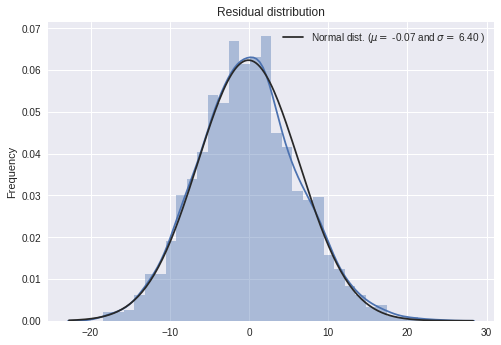

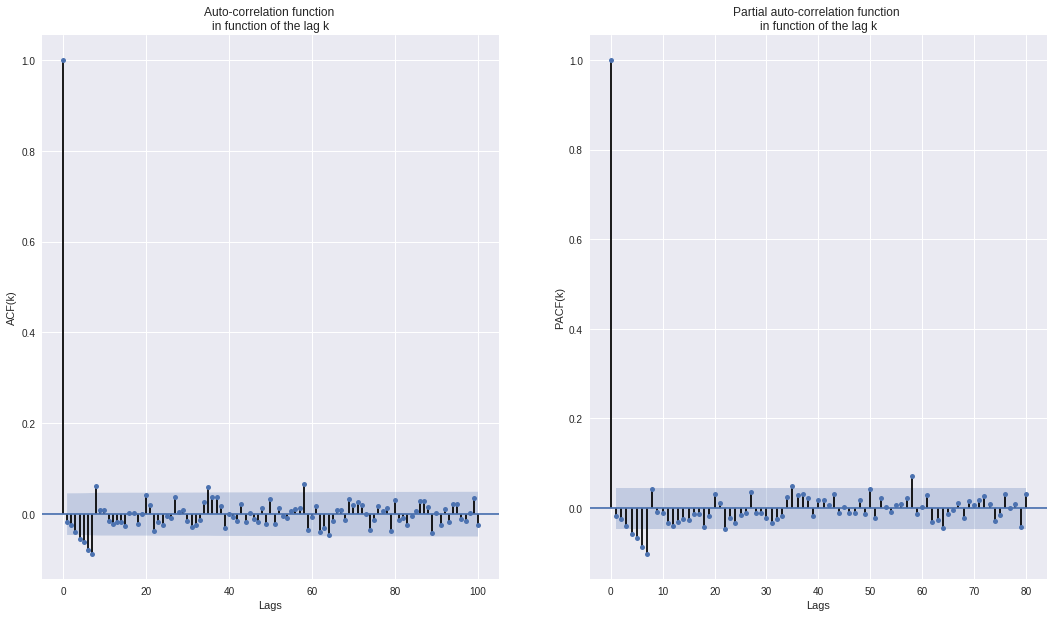

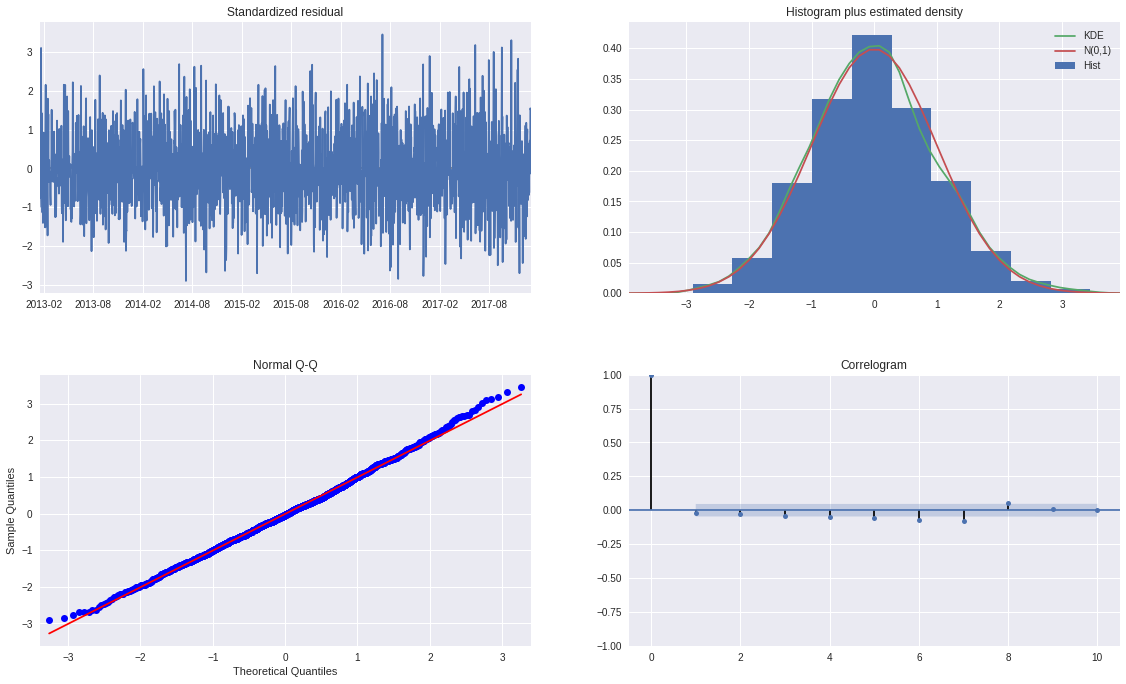

In [28]:
print(stats.normaltest(model.resid))
import seaborn as sns
sns.distplot(model.resid ,fit = stats.norm)
# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(model.resid)

# Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

PlotAutoCorrelation(model.resid, [100, 80])

model.plot_diagnostics()
plt.subplots_adjust(left=None, bottom=None, right=2, top=1.7, wspace=None, hspace=0.3)

### Interpretation
We know that the standardized residuals distribution has to follow a normal distribution with mean $0$ and variance $1$ which is a gaussian white noise.

## Cross-Validation
The objective is to split the train dataset in order to compare our predicted 3 months with the 3 last months in our test dataset which represents the 3 last months of the train dataset.

The first step is to split our train dataset in order to build our test dataset:
- Train set is from 2013-01-01 to 2017-09-30 inclusively.
- Test set is from 2017-10-01 to 2017-12-31 inclusively.

Let $SMAPE(X_t, \hat{X}_t)$ be the symmetric mean absolute percentage error which is used to calculate the error percentage and ignore outliers.

/usr/local/lib/python3.4/dist-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


SMAPE: 19.647734708682112


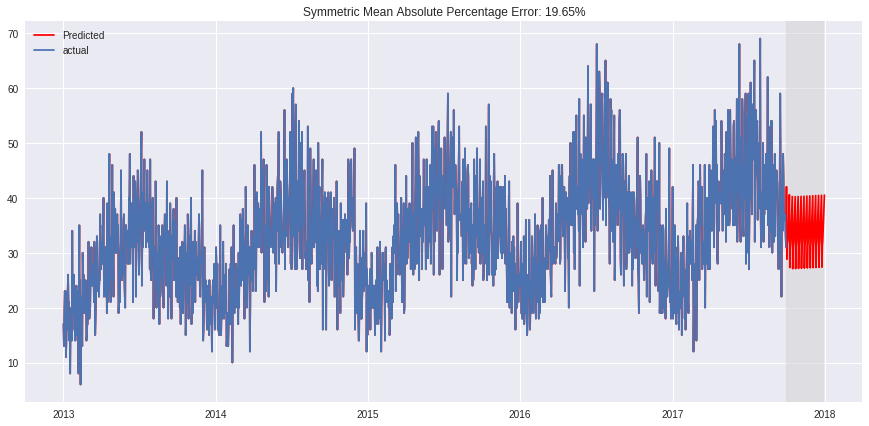

In [29]:
test_set = item['2017-10-01':]
train_set = item[:'2017-09-30']

mod = sm.tsa.statespace.SARIMAX(train_set,
                                trend='n',
                                order=non_seasonal_parameter,
                                seasonal_order=seasonal_parameter,
                                enforce_stationarity=False, 
                                enforce_invertibility=False)

model = mod.fit(disp=False)
forecast = pandas.DataFrame(model.predict(start = train_set.shape[0], end = train_set.shape[0] + test_set.shape[0] - 1))
forecast.columns = ['sales']
forecast.index.names = ['date']
train_forecast = train_set.append(forecast)

error = smape(test_set, forecast)['sales']
print("SMAPE: " + str(error))

plt.figure(figsize=(15, 7))
plt.title("Symmetric Mean Absolute Percentage Error: {0:.2f}%".format(error))
plt.plot(train_forecast, color='r', label="Predicted")
plt.axvspan(train_set.index[-1], train_forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(train_set, label="actual")
plt.legend()
plt.grid(True);